# Run configuration

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# To be able to import .py scripts stored under src/
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/cmpe593/term-project/src')
import os
import torch
from datetime import datetime


# Run parameters
model_type = "custom_FADE" # TODO: custom_FADE or "baseline"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##############################################################################
# PATHS
##############################################################################
base_path = "/content/drive/MyDrive"
project_dir = os.path.join(base_path, "Colab Notebooks", "cmpe593", "term-project")

## Dataset paths
dataset_split = "val2017"
coco_base_dir = f'{base_path}/coco'
images_dir = os.path.join(coco_base_dir, 'images', dataset_split)
annotations_path = os.path.join(coco_base_dir,
                                'annotations',
                                f'instances_{dataset_split}.json')

## Artifact paths (checkpoints, plots, metrics)
timestamp = "20250108_070741" # TODO: Enter the timestamp of the model checkpoint you want to import
results_dir = os.path.join(project_dir, 'results', timestamp)
checkpoint_dir = os.path.join(results_dir, 'checkpoints')
plot_dir = os.path.join(results_dir, 'plots')
metrics_dir = os.path.join(results_dir, 'metrics')


# Ensure artifact paths exist
for dir in [results_dir, checkpoint_dir, plot_dir, metrics_dir]:
  if not os.path.exists(dir):
    os.makedirs(dir)
    print(f'Directory created at {dir}')
  else:
    print(f'Directory {dir} already exists.')
##############################################################################

model_full_path = os.path.join(checkpoint_dir, "model_final.pth")
eval_results_path = os.path.join(metrics_dir, "evaluation_metrics.json")

Directory /content/drive/MyDrive/Colab Notebooks/cmpe593/term-project/results/20250108_070741 already exists.
Directory /content/drive/MyDrive/Colab Notebooks/cmpe593/term-project/results/20250108_070741/checkpoints already exists.
Directory /content/drive/MyDrive/Colab Notebooks/cmpe593/term-project/results/20250108_070741/plots already exists.
Directory /content/drive/MyDrive/Colab Notebooks/cmpe593/term-project/results/20250108_070741/metrics already exists.


# Evaluation Flow

In [3]:
from modelops.model_loader import load_model
from dataops.data_loader import get_data_loader, get_ground_truth

# Load the model
model = load_model(model_type, model_full_path, device, pretrained=False)

# Get data loader
dataloader = get_data_loader(images_dir, annotations_path, train=False)

Creating custom FADE model...


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading custom FADE model weights from /content/drive/MyDrive/Colab Notebooks/cmpe593/term-project/results/20250108_070741/checkpoints/model_final.pth


/content/drive/MyDrive/Colab Notebooks/cmpe593/term-project/src/modelops/model_loader.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path

Custom FADE model loaded.
Loaded custom_FADE model for evaluation on cuda.
Drive already mounted at /content/drive.

Image file directory: /content/drive/MyDrive/coco/images/val2017
Does image directory exist? True

Annotation file path: /content/drive/MyDrive/coco/annotations/instances_val2017.json
Does annotation file exist? True
Drive already mounted at /content/drive.

Generating image IDs...


Processing images: 100%|██████████| 5000/5000 [00:00<00:00, 924914.88file/s]

Total of 5000 image IDs were generated.
loading annotations into memory...


Done (t=0.72s)
creating index...
index created!

Dataset size is 5000
Creating dataloader object...


In [4]:
from modelops.inference import predict

# Get predictions
results = predict(model, dataloader, device)

# Load predictions into COCO format
# coco _dt: detections, _gt: ground truth
coco_gt = get_ground_truth(annotations_path)
coco_dt = coco_gt.loadRes(results)

100%|██████████| 5000/5000 [10:02<00:00,  8.30it/s]


loading annotations into memory...
Done (t=0.77s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.19s)
creating index...
index created!


In [5]:
# Create COCOeval object
from pycocotools.cocoeval import COCOeval
coco_evaluator = COCOeval(coco_gt, coco_dt, iouType='bbox')

# Run evaluation
coco_evaluator.evaluate()    # Run per-image evaluation
coco_evaluator.accumulate()  # Aggregate the results
coco_evaluator.summarize()   # Print the summary metrics

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=27.56s).
Accumulating evaluation results...
DONE (t=6.95s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.028
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.057
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.025
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.018
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.027
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.038
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.046
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.079
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.083
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.050
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=10

In [6]:
import json
# Extract key metrics from COCOeval
coco_metrics = {
    "Average Precision (AP) @[IoU=0.50:0.95 | area=all | maxDets=100]": coco_evaluator.stats[0],
    "Average Precision (AP) @[IoU=0.50      | area=all | maxDets=100]": coco_evaluator.stats[1],
    "Average Precision (AP) @[IoU=0.75      | area=all | maxDets=100]": coco_evaluator.stats[2],
    "Average Precision (AP) @[IoU=0.50:0.95 | area=small | maxDets=100]": coco_evaluator.stats[3],
    "Average Precision (AP) @[IoU=0.50:0.95 | area=medium | maxDets=100]": coco_evaluator.stats[4],
    "Average Precision (AP) @[IoU=0.50:0.95 | area=large | maxDets=100]": coco_evaluator.stats[5],
    "Average Recall (AR) @[IoU=0.50:0.95 | area=all | maxDets=1]": coco_evaluator.stats[6],
    "Average Recall (AR) @[IoU=0.50:0.95 | area=all | maxDets=10]": coco_evaluator.stats[7],
    "Average Recall (AR) @[IoU=0.50:0.95 | area=all | maxDets=100]": coco_evaluator.stats[8],
    "Average Recall (AR) @[IoU=0.50:0.95 | area=small | maxDets=100]": coco_evaluator.stats[9],
    "Average Recall (AR) @[IoU=0.50:0.95 | area=medium | maxDets=100]": coco_evaluator.stats[10],
    "Average Recall (AR) @[IoU=0.50:0.95 | area=large | maxDets=100]": coco_evaluator.stats[11],
}

# Save to JSON file
with open(eval_results_path, "w") as f:
    json.dump(coco_metrics, f, indent=4)

print(f"Evaluation metrics saved to {eval_results_path}")

# Display Ground Truth and Predictions

In [9]:
img_ids = coco_gt.getImgIds()

best_img_id = None
best_score = 0.0

for img_id in img_ids:
    # Load predictions for this image
    ann_ids_dt = coco_dt.getAnnIds(imgIds=img_id)
    ann_dt = coco_dt.loadAnns(ann_ids_dt)

    if not ann_dt:
        # No predictions for this image, skip
        continue

    # Get the maximum confidence for this image
    max_conf = max(ann["score"] for ann in ann_dt)

    # If this is higher than our current best, update
    if max_conf > best_score:
        best_score = max_conf
        best_img_id = img_id

print(f"Image with the single highest confidence = {best_img_id} (score = {best_score:.4f})")

Image with the single highest confidence = 226417 (score = 0.9995)


loading annotations into memory...
Done (t=0.47s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.17s)
creating index...
index created!


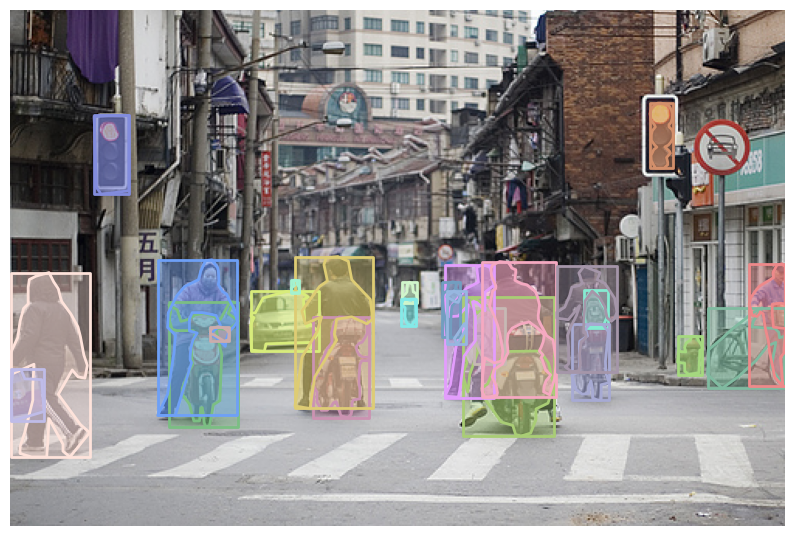

In [10]:
import os
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt

coco_gt = COCO(annotations_path)   # Ground-truth COCO object
coco_dt = coco_gt.loadRes(results)  # Detection COCO object

# Get the image info
img_info = coco_gt.loadImgs(best_img_id)[0]
image_path = os.path.join(images_dir, img_info["file_name"])

# Load the image
img = io.imread(image_path)

# Grab ground-truth annotations for this image
ann_ids_gt = coco_gt.getAnnIds(imgIds=best_img_id)
anns_gt = coco_gt.loadAnns(ann_ids_gt)

# Grab detection annotations
ann_ids_dt = coco_dt.getAnnIds(imgIds=best_img_id)
anns_dt = coco_dt.loadAnns(ann_ids_dt)

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')

# Draw ground-truth bboxes
coco_gt.showAnns(anns_gt, draw_bbox=True)

plt.show()

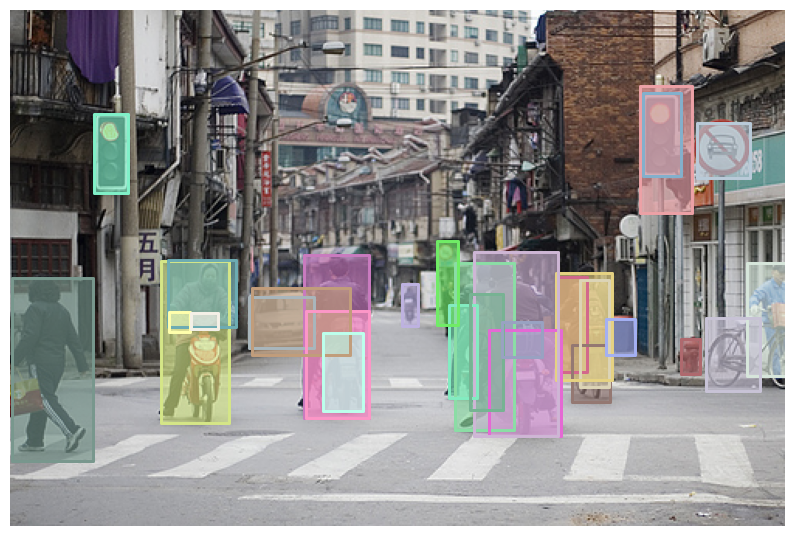

In [12]:
# Get the image info
img_info = coco_gt.loadImgs(best_img_id)[0]
image_path = os.path.join(images_dir, img_info["file_name"])

# Load the image
img = io.imread(image_path)

# Grab detection annotations
ann_ids_dt = coco_dt.getAnnIds(imgIds=best_img_id)
anns_dt = coco_dt.loadAnns(ann_ids_dt)

plt.figure(figsize=(10, 8))
plt.imshow(img)
plt.axis('off')

# Filter low confidence predictions
threshold = 0.5
anns_dt_filtered = [ann for ann in anns_dt if ann.get("score", 0) >= threshold]

# Draw predicted bboxes
coco_gt.showAnns(anns_dt_filtered, draw_bbox=True)

plt.show()